In [1]:
from pyEDM import *
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
import geopandas as gpd
from shapely.geometry import Polygon
import rasterio
import xarray as xr
from mpl_toolkits.axes_grid1 import make_axes_locatable
import fiona
import rasterio.mask
from descartes import PolygonPatch
from rasterio.plot import show
from tqdm import tqdm
import datetime

In [2]:
croplands_vars_dir = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/VariablesByLandCover2016/Variables_Croplands/'
grasslands_vars_dir = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/VariablesByLandCover2016/Variables_Grasslands/'
savannas_vars_dir = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/VariablesByLandCover2016/Variables_Savannas/'

EA_TS_DIR = '/home/rgreen/DroughtEDM/Data/EA_TS/Final/'

Africa_simplex = '/home/rgreen/DroughtEDM/Data/Africa_simplex/' #out directory

Admin_boundaries = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/AdminBoundaries/'

In [3]:
precip_dir = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/CHIRPS/Resampled/' 
temp_dir = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/CHIRTS/Dekads/'
ndvi_dir = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/eMODIS_NDVI/Resampled/' 
sm_dir = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/FLDAS_SM/Dekads/' 
pet_dir = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/Hobbins_ET/Resampled/'
lst_dir = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/LST/Resampled/'

In [4]:
#anomaly out directories
anomaly_ndvi = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/eMODIS_NDVI/Anomaly/'
anomaly_precip = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/CHIRPS/Anomaly/'
anomaly_temp = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/CHIRTS/Anomaly/'
anomaly_sm = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/FLDAS_SM/Anomaly/'
anomaly_pet = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/Hobbins_ET/Anomaly/'
anomaly_lst = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/LST/Anomaly/'

In [5]:
ea_adminbds = Admin_boundaries + 'gadm36_EastAfrica.shp'
ea_bndry = gpd.read_file(ea_adminbds)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
Africa_basemap = world[world['continent'] == 'Africa']
EA_countries = ['Burundi', 'Djibouti', 'Eritrea', 'Ethiopia', 'Kenya', 'Rwanda', 'Sudan', 'S. Sudan', 'Somalia', 'Somaliland', 'South Sudan', 'Tanzania', 'Uganda']
EastAfrica_basemap = world[world['name'].isin(EA_countries)]
EastAfrica_basemap.to_file(Admin_boundaries + 'EastAfrica_countries.shp')

In [6]:
Tanzania = EastAfrica_basemap[EastAfrica_basemap.name == 'Tanzania']
Kenya = EastAfrica_basemap[EastAfrica_basemap.name == 'Kenya']
Sudan = EastAfrica_basemap[EastAfrica_basemap.name == 'Sudan']
Burundi = EastAfrica_basemap[EastAfrica_basemap.name == 'Burundi']
Eritrea = EastAfrica_basemap[EastAfrica_basemap.name == 'Eritrea']
Ethiopia = EastAfrica_basemap[EastAfrica_basemap.name == 'Ethiopia']
Djibouti = EastAfrica_basemap[EastAfrica_basemap.name == 'Djibouti']
Uganda = EastAfrica_basemap[EastAfrica_basemap.name == 'Uganda']
Rwanda = EastAfrica_basemap[EastAfrica_basemap.name == 'Rwanda']
SSudan = EastAfrica_basemap[EastAfrica_basemap.name == 'S. Sudan']
Somalia = EastAfrica_basemap[EastAfrica_basemap.name.isin(['Somalia', 'Somaliland'])]

Tanzania.to_file(Admin_boundaries + 'Tanzania.shp')
Kenya.to_file(Admin_boundaries + 'Kenya.shp')
Sudan.to_file(Admin_boundaries + 'Sudan.shp')
Burundi.to_file(Admin_boundaries + 'Burundi.shp')
Eritrea.to_file(Admin_boundaries + 'Eritrea.shp')
Ethiopia.to_file(Admin_boundaries + 'Ethiopia.shp')
Djibouti.to_file(Admin_boundaries + 'Djibouti.shp')
Uganda.to_file(Admin_boundaries + 'Uganda.shp')
Rwanda.to_file(Admin_boundaries + 'Rwanda.shp')
SSudan.to_file(Admin_boundaries + 'SSudan.shp')
Somalia.to_file(Admin_boundaries + 'Somalia.shp')

In [7]:
begin = pd.datetime(2002,7,1)
end = pd.datetime(2016,12,31)
dtrange = pd.date_range(begin, end)
days = list(range(0,5298)) #length of dtrange
daysDF = pd.DataFrame({'Days': days}, index=dtrange)
d = daysDF.index.day - np.clip((daysDF.index.day-1) // 10, 0, 2)*10 - 1 
dekaddates = daysDF.index.values - np.array(d, dtype="timedelta64[D]")
dekads = daysDF.groupby(dekaddates).mean()
dekads = dekads.index

In [8]:
def pixelwise_ts_table(in_dir):
    
    '''
    This function searches through the file directory and creates a dataframe of pixel values over time from rasters
    based on a given keyword describing the environmental variable of interest to generate a raster time series stack 
    
   In the output dataframe, columns are each pixel extracted from the raster (read squentially into a list)
   and rows are the same pixel over time (dekads going down)
    
    Args:
    - in_dir: path to the input directory
    -keyword: string that is unique to the environmental variable
        options: ['chirps', 'lst', 'ndvi', 'pet', 'SM', 'Tmax']
    '''
    files=np.array(sorted(os.listdir(in_dir)))
    tifs = pd.Series(files).str.contains('.tif')
    files = files[tifs]#[0:522]
    
    pixelwise_TS = []
    
    for filename in tqdm(files): 
        
        open_file = xr.open_rasterio(in_dir+filename).sel(band=1)
        array = open_file.values
    
        pixel_list = array.ravel().tolist()
   
        pixelwise_TS.append(pixel_list)

    return pd.DataFrame(pixelwise_TS)

In [9]:
temp_crops_table = pixelwise_ts_table(anomaly_temp + 'Croplands_Anomaly/')
precip_crops_table = pixelwise_ts_table(anomaly_precip + 'Croplands_Anomaly/')
ndvi_crops_table = pixelwise_ts_table(anomaly_ndvi + 'Croplands_Anomaly/')

100%|██████████| 522/522 [00:10<00:00, 48.28it/s]


In [10]:
temp_grass_table = pixelwise_ts_table(anomaly_temp + 'Grasslands_Anomaly/')
precip_grass_table = pixelwise_ts_table(anomaly_precip + 'Grasslands_Anomaly/')
ndvi_grass_table = pixelwise_ts_table(anomaly_ndvi + 'Grasslands_Anomaly/')

100%|██████████| 522/522 [00:09<00:00, 52.96it/s]


In [11]:
temp_sav_table = pixelwise_ts_table(anomaly_temp + 'Savannas_Anomaly/')
precip_sav_table = pixelwise_ts_table(anomaly_precip + 'Savannas_Anomaly/')
ndvi_sav_table = pixelwise_ts_table(anomaly_ndvi + 'Savannas_Anomaly/')

100%|██████████| 522/522 [00:09<00:00, 53.79it/s]


In [12]:
def growing_pixelwise_simplex(table, ed, pi, rs_rows, rs_cols, train_start_date, train_end_date, test_start_date, test_end_date):
    
    '''
    This function computes the simplex prediction skill for a given embedding dimensions, prediction interval, land cover and environmental variable
    across pixels given a table of pixel values across the time of growing season given the months leading up to the rains
    for a region from the function pixelwise_ts_table 

    The result is an np.array of simplex error values reshaped back into the shape of the original raster image
    
    Args:
    - table: input table from pixelwise_ts_table result of each pixel's time series
    - train: portion of data library used to train (string of range with space between values)
    - test: portion of data libary used to test (string of range with space between values) 
    - ed: embedding dimension
    - pi: prediction interval (Tp) 
    - rs_rows: number of rows to reshape list into original raster size
    -rs_cols: number of columns to reshape list into original raster size
   
    '''

    simplex_out_df = []
    #table_chunk = table.loc[:100,500:510]
    
    for column in tqdm(table):
        #print(column)
        if table[column].isnull().values.any():
            #print('null')
            simplex_out_df.append(np.nan)
        else:
          
            interim_df = pd.DataFrame({'Time': dekads, 'Data': table[column]}) #'Time': dekads
            train_season = interim_df[(interim_df['Time'].dt.month >= train_start_date) & (interim_df['Time'].dt.month <= train_end_date)]
            train_season.reset_index()
            
            test_season = interim_df[(interim_df['Time'].dt.month >= test_start_date) & (interim_df['Time'].dt.month <= test_end_date)]
            test_season.reset_index()
            
            simplex_result = Simplex(dataFrame = interim_df, lib = str(train_season.index[0]) + ' ' + str(train_season.index[-1]), pred = str(test_season.index[0]) + ' ' + str(test_season.index[-1]), E = ed, Tp = pi, columns = 'Data', target = 'Data', showPlot = False)
            error = ComputeError(list(simplex_result.Observations), list(simplex_result.Predictions))
            MAE = list(error.values())[0]
            RMSE = list(error.values())[1]
            rho = list(error.values())[2]
            
            simplex_out_df.append(rho) #adjust measure depending on output interest
            
    return(np.reshape(simplex_out_df, (rs_rows,rs_cols)))

In [13]:
temp_crops_mam = growing_pixelwise_simplex(temp_crops_table, 2, 6, 800, 730, 1, 2, 3, 5)
precip_crops_mam = growing_pixelwise_simplex(precip_crops_table, 2, 6, 800, 730, 1, 2, 3, 5)
ndvi_crops_mam = growing_pixelwise_simplex(ndvi_crops_table, 2, 6, 800, 730, 1, 2, 3, 5)


584000it [04:21, 2237.45it/s]                     
584000it [04:34, 2128.16it/s]                      
584000it [04:36, 2111.69it/s]                      


In [14]:
temp_grass_mam = growing_pixelwise_simplex(temp_grass_table, 2, 6, 800, 730, 1, 2, 3, 5)
precip_grass_mam = growing_pixelwise_simplex(precip_grass_table, 2, 6, 800, 730, 1, 2, 3, 5)
ndvi_grass_mam = growing_pixelwise_simplex(ndvi_grass_table, 2, 6, 800, 730, 1, 2, 3, 5)


584000it [18:14, 533.45it/s]                       
584000it [19:30, 498.90it/s]                       
584000it [19:28, 499.87it/s]                       


In [ ]:
temp_sav_mam = growing_pixelwise_simplex(temp_sav_table, 2, 6, 800, 730, 1, 2, 3, 5)
precip_sav_mam = growing_pixelwise_simplex(precip_sav_table, 2, 6, 800, 730, 1, 2, 3, 5)
ndvi_sav_mam = growing_pixelwise_simplex(ndvi_sav_table, 2, 6, 800, 730, 1, 2, 3, 5)


235169it [02:22, 182.15it/s]                       

In [ ]:
temp_crops_ond = growing_pixelwise_simplex(temp_crops_table, 2, 6, 800, 730, 8, 9, 10, 12)
precip_crops_ond = growing_pixelwise_simplex(precip_crops_table, 2, 6, 800, 730, 8, 9, 10, 12)
ndvi_crops_ond = growing_pixelwise_simplex(ndvi_crops_table, 2, 6, 800, 730, 8, 9, 10, 12)


In [ ]:
temp_grass_ond = growing_pixelwise_simplex(temp_grass_table, 2, 6, 800, 730, 8, 9, 10, 12)
precip_grass_ond = growing_pixelwise_simplex(precip_grass_table, 2, 6, 800, 730, 8, 9, 10, 12)
ndvi_grass_ond = growing_pixelwise_simplex(ndvi_grass_table, 2, 6, 800, 730, 8, 9, 10, 12)


In [ ]:
temp_sav_ond = growing_pixelwise_simplex(temp_sav_table, 2, 6, 800, 730, 8, 9, 10, 12)
precip_sav_ond = growing_pixelwise_simplex(precip_sav_table, 2, 6, 800, 730, 8, 9, 10, 12)
ndvi_sav_ond = growing_pixelwise_simplex(ndvi_sav_table, 2, 6, 800, 730, 8, 9, 10, 12)


In [46]:
def array2tiff(array, in_dir, out_dir, out_name):
    
    '''
    This function converts a 2D array into a tif using the profile of an existing tif

    '''

    with rasterio.open(in_dir+ os.listdir(in_dir)[0]) as src:
        profile = src.profile

    with rasterio.open(out_dir + out_name + '.tif', 'w', **profile) as dst:
        data = array
        data = data.astype(np.float32)
        data[data<=0] = np.nan
        dst.write(data, indexes=1)

In [47]:
array2tiff(temp_crops_mam, croplands_vars_dir, Africa_simplex, 'temp_crops_mam')
array2tiff(precip_crops_mam, croplands_vars_dir, Africa_simplex, 'precip_crops_mam')
array2tiff(ndvi_crops_mam, croplands_vars_dir, Africa_simplex, 'ndvi_crops_mam')


array2tiff(temp_grass_mam, grasslands_vars_dir, Africa_simplex, 'temp_grass_mam')
array2tiff(precip_grass_mam, grasslands_vars_dir, Africa_simplex, 'precip_grass_mam')
array2tiff(ndvi_grass_mam, grasslands_vars_dir, Africa_simplex, 'ndvi_grass_mam')

array2tiff(temp_sav_mam, savannas_vars_dir, Africa_simplex, 'temp_sav_mam')
array2tiff(precip_sav_mam, savannas_vars_dir, Africa_simplex, 'precip_sav_mam')
array2tiff(ndvi_sav_mam, savannas_vars_dir, Africa_simplex, 'ndvi_sav_mam')

/home/rgreen/miniconda3/envs/edm/lib/python3.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in less_equal


In [48]:
array2tiff(temp_crops_ond, croplands_vars_dir, Africa_simplex, 'temp_crops_ond')
array2tiff(precip_crops_ond, croplands_vars_dir, Africa_simplex, 'precip_crops_ond')
array2tiff(ndvi_crops_ond, croplands_vars_dir, Africa_simplex, 'ndvi_crops_ond')


array2tiff(temp_grass_ond, grasslands_vars_dir, Africa_simplex, 'temp_grass_ond')
array2tiff(precip_grass_ond, grasslands_vars_dir, Africa_simplex, 'precip_grass_ond')
array2tiff(ndvi_grass_ond, grasslands_vars_dir, Africa_simplex, 'ndvi_grass_ond')

array2tiff(temp_sav_ond, savannas_vars_dir, Africa_simplex, 'temp_sav_ond')
array2tiff(precip_sav_ond, savannas_vars_dir, Africa_simplex, 'precip_sav_ond')
array2tiff(ndvi_sav_ond, savannas_vars_dir, Africa_simplex, 'ndvi_sav_ond')

/home/rgreen/miniconda3/envs/edm/lib/python3.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in less_equal


In [49]:
def mask_raster_shp(shp, raster, out_name, in_dir, out_dir):
    
    '''
    This function masks a raster to the shape of a smaller shapefile and creates a new raster
    
    '''
    with fiona.open(shp, "r") as shapefile:
        shapes = [feature["geometry"] for feature in shapefile]
    with rasterio.open(in_dir + raster) as src:
        out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
        out_meta = src.meta

    out_meta.update({"driver": "GTiff",
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_transform})

    with rasterio.open(out_dir + out_name, "w", **out_meta) as dest:
        dest.write(out_image)

In [50]:
mask_raster_shp(ea_adminbds, 'temp_crops_mam.tif', 'temp_eastafrica_crops_mam.tif', Africa_simplex, Africa_simplex)
mask_raster_shp(ea_adminbds, 'precip_crops_mam.tif', 'precip_eastafrica_crops_mam.tif', Africa_simplex, Africa_simplex)
mask_raster_shp(ea_adminbds, 'ndvi_crops_mam.tif', 'ndvi_eastafrica_crops_mam.tif', Africa_simplex, Africa_simplex)

mask_raster_shp(ea_adminbds, 'temp_grass_mam.tif', 'temp_eastafrica_grass_mam.tif', Africa_simplex, Africa_simplex)
mask_raster_shp(ea_adminbds, 'precip_grass_mam.tif', 'precip_eastafrica_grass_mam.tif', Africa_simplex, Africa_simplex)
mask_raster_shp(ea_adminbds, 'ndvi_grass_mam.tif', 'ndvi_eastafrica_grass_mam.tif', Africa_simplex, Africa_simplex)


mask_raster_shp(ea_adminbds, 'temp_sav_mam.tif', 'temp_eastafrica_sav_mam.tif', Africa_simplex, Africa_simplex)
mask_raster_shp(ea_adminbds, 'precip_sav_mam.tif', 'precip_eastafrica_sav_mam.tif', Africa_simplex, Africa_simplex)
mask_raster_shp(ea_adminbds, 'ndvi_sav_mam.tif', 'ndvi_eastafrica_sav_mam.tif', Africa_simplex, Africa_simplex)

In [51]:
mask_raster_shp(ea_adminbds, 'temp_crops_ond.tif', 'temp_eastafrica_crops_ond.tif', Africa_simplex, Africa_simplex)
mask_raster_shp(ea_adminbds, 'precip_crops_ond.tif', 'precip_eastafrica_crops_ond.tif', Africa_simplex, Africa_simplex)
mask_raster_shp(ea_adminbds, 'ndvi_crops_ond.tif', 'ndvi_eastafrica_crops_ond.tif', Africa_simplex, Africa_simplex)

mask_raster_shp(ea_adminbds, 'temp_grass_ond.tif', 'temp_eastafrica_grass_ond.tif', Africa_simplex, Africa_simplex)
mask_raster_shp(ea_adminbds, 'precip_grass_ond.tif', 'precip_eastafrica_grass_ond.tif', Africa_simplex, Africa_simplex)
mask_raster_shp(ea_adminbds, 'ndvi_grass_ond.tif', 'ndvi_eastafrica_grass_ond.tif', Africa_simplex, Africa_simplex)


mask_raster_shp(ea_adminbds, 'temp_sav_ond.tif', 'temp_eastafrica_sav_ond.tif', Africa_simplex, Africa_simplex)
mask_raster_shp(ea_adminbds, 'precip_sav_ond.tif', 'precip_eastafrica_sav_ond.tif', Africa_simplex, Africa_simplex)
mask_raster_shp(ea_adminbds, 'ndvi_sav_ond.tif', 'ndvi_eastafrica_sav_ond.tif', Africa_simplex, Africa_simplex)

In [64]:
temp_eastafrica_crop_mam = rasterio.open(Africa_simplex + 'temp_eastafrica_crops_mam.tif')
precip_eastafrica_crop_mam = rasterio.open(Africa_simplex + 'precip_eastafrica_crops_mam.tif')
ndvi_eastafrica_crop_mam = rasterio.open(Africa_simplex + 'ndvi_eastafrica_crops_mam.tif')

temp_eastafrica_grass_mam = rasterio.open(Africa_simplex + 'temp_eastafrica_grass_mam.tif')
precip_eastafrica_grass_mam = rasterio.open(Africa_simplex + 'precip_eastafrica_grass_mam.tif')
ndvi_eastafrica_grass_mam = rasterio.open(Africa_simplex + 'ndvi_eastafrica_grass_mam.tif')

temp_eastafrica_sav_mam = rasterio.open(Africa_simplex + 'temp_eastafrica_sav_mam.tif')
precip_eastafrica_sav_mam = rasterio.open(Africa_simplex + 'precip_eastafrica_sav_mam.tif')
ndvi_eastafrica_sav_mam = rasterio.open(Africa_simplex + 'ndvi_eastafrica_sav_mam.tif')

In [65]:
temp_eastafrica_crop_ond = rasterio.open(Africa_simplex + 'temp_eastafrica_crops_ond.tif')
precip_eastafrica_crop_ond = rasterio.open(Africa_simplex + 'precip_eastafrica_crops_ond.tif')
ndvi_eastafrica_crop_ond = rasterio.open(Africa_simplex + 'ndvi_eastafrica_crops_ond.tif')

temp_eastafrica_grass_ond = rasterio.open(Africa_simplex + 'temp_eastafrica_grass_ond.tif')
precip_eastafrica_grass_ond = rasterio.open(Africa_simplex + 'precip_eastafrica_grass_ond.tif')
ndvi_eastafrica_grass_ond = rasterio.open(Africa_simplex + 'ndvi_eastafrica_grass_ond.tif')

temp_eastafrica_sav_ond = rasterio.open(Africa_simplex + 'temp_eastafrica_sav_ond.tif')
precip_eastafrica_sav_ond = rasterio.open(Africa_simplex + 'precip_eastafrica_sav_ond.tif')
ndvi_eastafrica_sav_ond = rasterio.open(Africa_simplex + 'ndvi_eastafrica_sav_ond.tif')

/home/rgreen/miniconda3/envs/edm/lib/python3.7/site-packages/matplotlib/image.py:421: RuntimeWarning: overflow encountered in true_divide
  A_scaled /= ((a_max - a_min) / 0.8)
/home/rgreen/miniconda3/envs/edm/lib/python3.7/site-packages/matplotlib/colors.py:973: RuntimeWarning: overflow encountered in true_divide
  resdat /= (vmax - vmin)
/home/rgreen/miniconda3/envs/edm/lib/python3.7/site-packages/matplotlib/image.py:421: RuntimeWarning: overflow encountered in true_divide
  A_scaled /= ((a_max - a_min) / 0.8)
/home/rgreen/miniconda3/envs/edm/lib/python3.7/site-packages/matplotlib/colors.py:973: RuntimeWarning: overflow encountered in true_divide
  resdat /= (vmax - vmin)
/home/rgreen/miniconda3/envs/edm/lib/python3.7/site-packages/matplotlib/image.py:421: RuntimeWarning: overflow encountered in true_divide
  A_scaled /= ((a_max - a_min) / 0.8)
/home/rgreen/miniconda3/envs/edm/lib/python3.7/site-packages/matplotlib/colors.py:973: RuntimeWarning: overflow encountered in true_divide
  r

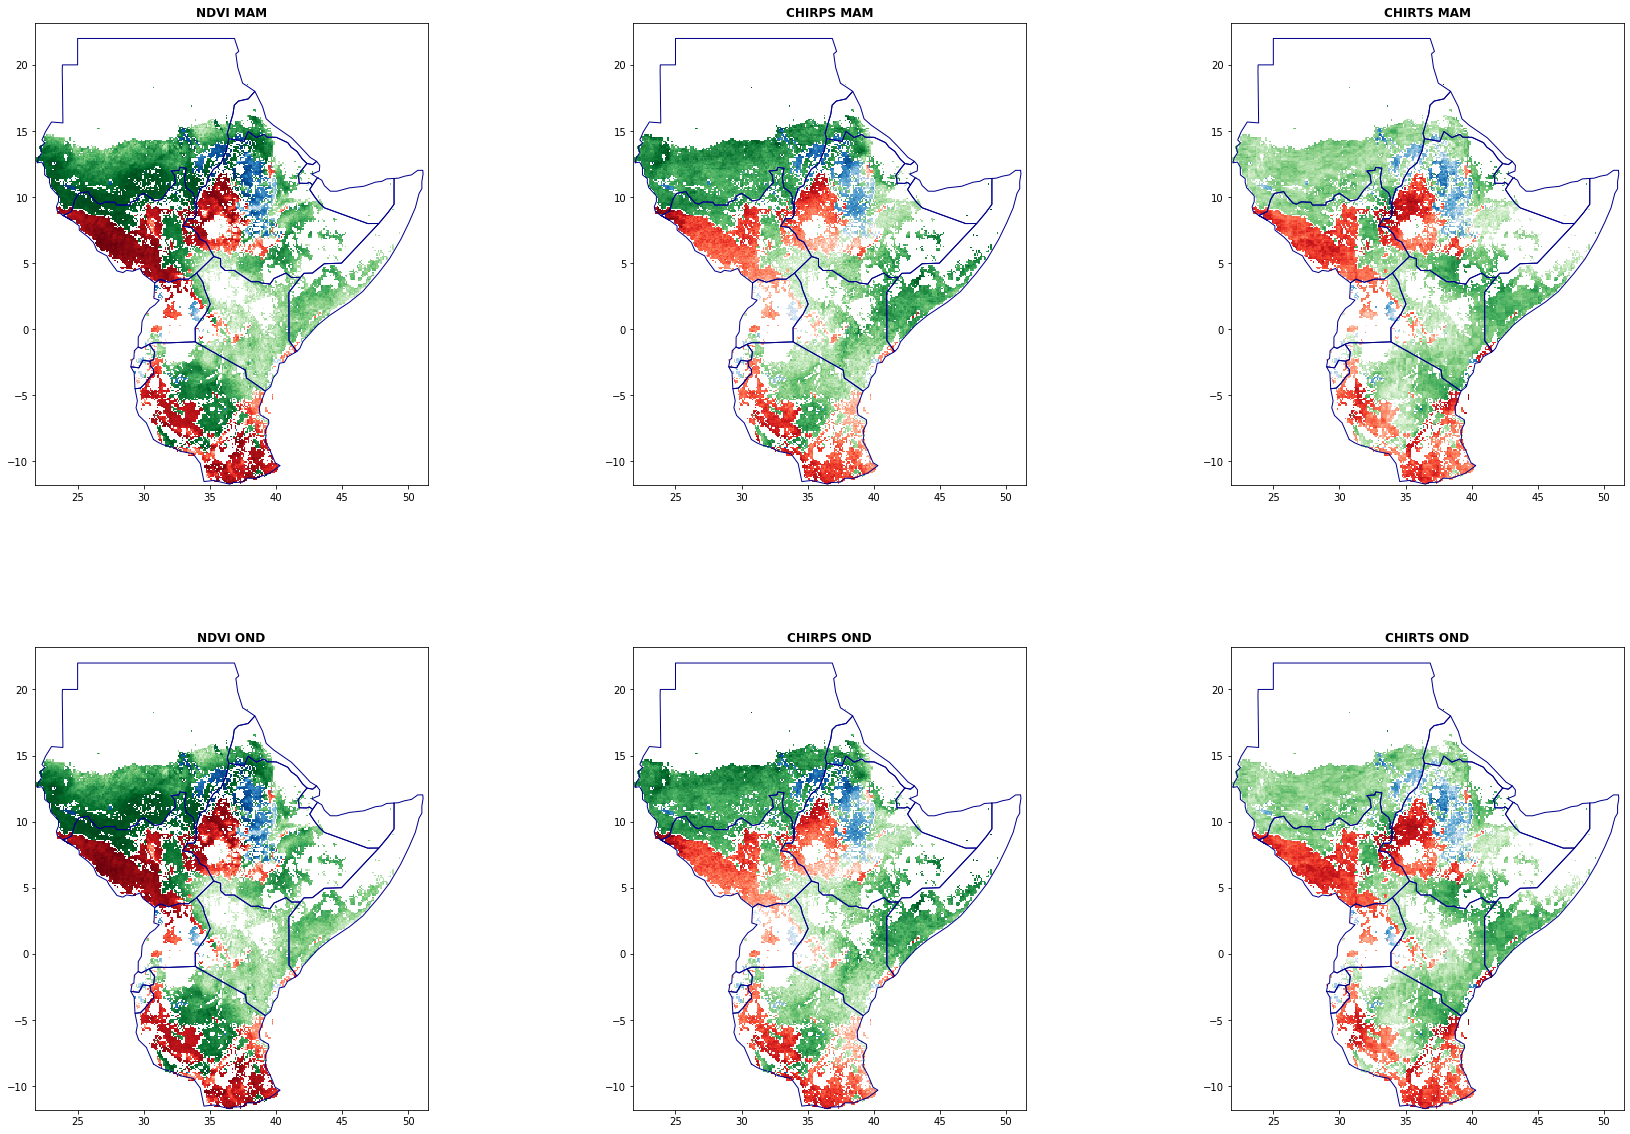

In [74]:
fig, axs = plt.subplots(2, 3, figsize = (30, 20))

axs = axs.ravel()
fig.subplots_adjust(wspace= 0.25, hspace = 0.35)
fig = plt.gcf()

show(ndvi_eastafrica_crop_mam, ax=axs[0], cmap = 'Blues', title = 'NDVI MAM')
show(ndvi_eastafrica_sav_mam, ax=axs[0], cmap = 'Reds')
show(ndvi_eastafrica_grass_mam, ax=axs[0], cmap = 'Greens')
EastAfrica_basemap.plot(ax=axs[0], facecolor='none', edgecolor='darkblue', vmin = 0, vmax = 1)
    
show(precip_eastafrica_crop_mam, ax=axs[1], cmap = 'Blues', title = 'CHIRPS MAM')
show(precip_eastafrica_sav_mam, ax=axs[1], cmap = 'Reds')
show(precip_eastafrica_grass_mam, ax=axs[1], cmap = 'Greens')
EastAfrica_basemap.plot(ax=axs[1], facecolor='none', edgecolor='darkblue', vmin = 0, vmax = 1)

show(temp_eastafrica_crop_mam, ax=axs[2], cmap = 'Blues', title = 'CHIRTS MAM')
show(temp_eastafrica_sav_mam, ax=axs[2], cmap = 'Reds')
show(temp_eastafrica_grass_mam, ax=axs[2], cmap = 'Greens')
EastAfrica_basemap.plot(ax=axs[2], facecolor='none', edgecolor='darkblue', vmin = 0, vmax = 1)

show(ndvi_eastafrica_crop_ond, ax=axs[3], cmap = 'Blues', title = 'NDVI OND')
show(ndvi_eastafrica_sav_ond, ax=axs[3], cmap = 'Reds')
show(ndvi_eastafrica_grass_ond, ax=axs[3], cmap = 'Greens')
EastAfrica_basemap.plot(ax=axs[3], facecolor='none', edgecolor='darkblue', vmin = 0, vmax = 1)
    
show(precip_eastafrica_crop_ond, ax=axs[4], cmap = 'Blues', title = 'CHIRPS OND')
show(precip_eastafrica_sav_ond, ax=axs[4], cmap = 'Reds')
show(precip_eastafrica_grass_ond, ax=axs[4], cmap = 'Greens')
EastAfrica_basemap.plot(ax=axs[4], facecolor='none', edgecolor='darkblue', vmin = 0, vmax = 1)

show(temp_eastafrica_crop_ond, ax=axs[5], cmap = 'Blues', title = 'CHIRTS OND')
show(temp_eastafrica_sav_ond, ax=axs[5], cmap = 'Reds')
show(temp_eastafrica_grass_ond, ax=axs[5], cmap = 'Greens')
EastAfrica_basemap.plot(ax=axs[5], facecolor='none', edgecolor='darkblue', vmin = 0, vmax = 1)

plt.savefig('/home/rgreen/mam_ond.png', dpi = 300)